In [1]:
from torch.autograd import Variable

In [2]:
from torch.nn.functional import softmax

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
help(F.tanh)

Help on function tanh in module torch.nn.functional:

tanh(input)
    tanh(input) -> Tensor
    
    Applies element-wise,
    :math:`\text{Tanh}(x) = \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}`
    
    See :class:`~torch.nn.Tanh` for more details.



In [296]:
from torchvision import datasets
import torchvision.transforms as transforms

In [297]:
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root = 'data', train = True,
                                   download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False,
                                  download = True, transform = transform)

In [298]:
train_data.data.numpy().shape

(60000, 28, 28)

In [299]:
import numpy as np
np.eye(10)[train_data.targets.numpy()][train_data.targets.numpy() == 0].shape

(5923, 10)

In [300]:
test_data.data.numpy().shape

(10000, 28, 28)

In [301]:
train_label = train_data.targets.numpy()

In [302]:
test_label = test_data.targets.numpy()

In [303]:
train_data = train_data.data.view(60000, -1).numpy()

In [304]:
test_data = test_data.data.view(10000, -1).numpy()

In [305]:
test_data.shape

(10000, 784)

In [306]:
train_label.shape

(60000,)

In [307]:
test_label.shape

(10000,)

In [17]:
train_label[train_label > 6].shape

(18065,)

In [177]:
train_sets = [train_data[train_label == i] for i in [7, 8, 9]]
test_sets = [test_data[test_label ==i] for i in [7, 8, 9]]
train_labels = [train_label[train_label == i] for i in [7, 8, 9]]
test_labels = [test_label[test_label == i] for i in [7, 8, 9]]

In [24]:
train_size = min(map(len, train_sets))

In [25]:
test_size = min(map(len, test_sets))

In [26]:
test_size

974

In [27]:
train_data = np.array([[train_sets[j][i] for j in range(3)] for i in range(train_size)])
train_label = np.array([[train_labels[j][i] for j in range(3)] for i in range(train_size)])

test_data = np.array([[test_sets[j][i] for j in range(3)] for i in range(test_size)])
test_label = np.array([[test_labels[j][i] for j in range(3)] for i in range(test_size)])

In [28]:
test_data.shape

(974, 3, 784)

In [308]:
train_data = train_data / 255.0

In [309]:
test_data = test_data / 255.0

In [31]:
train_label = train_label * 0.75 - 7

In [32]:
test_label = test_label * 0.75 - 7

In [33]:
train_label = train_label + 1.25

In [34]:
test_label = test_label + 1.25

In [35]:
train_data[0].max()

1.0

In [29]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [30]:
import torch.utils.data as Data

In [31]:
import torch.nn.functional as F

In [39]:
for _, (x, y) in enumerate(loader):
    print(x)
    break

NameError: name 'loader' is not defined

In [86]:
help(Data)

Help on package torch.utils.data in torch.utils:

NAME
    torch.utils.data

PACKAGE CONTENTS
    _utils (package)
    dataloader
    dataset
    distributed
    sampler

FILE
    /Users/zhipeng/Library/Python/3.7/lib/python/site-packages/torch/utils/data/__init__.py




In [40]:
loader = Data.DataLoader(Data.TensorDataset(torch.FloatTensor(train_data), torch.FloatTensor(train_label)), 
                        batch_size = 5, shuffle = True)

In [1288]:
class AttentionL2RNet(nn.Module):
    def __init__(self):
        super(AttentionL2RNet, self).__init__()
        
        self.q_h1 = nn.Linear(784, 256)
        #self.q_h2 = nn.Linear(256, 784)
        self.q_b = nn.LayerNorm(256)
        self.q_h3 = nn.Linear(256, 32)
        
        self.v_h1 = nn.Linear(784, 256)
        #self.v_h2 = nn.Linear(256, 784)
        self.v_b = nn.LayerNorm(256)
        self.v_h3 = nn.Linear(256, 32)
        
        self.k_h1 = nn.Linear(784, 256)
        #self.k_h2 = nn.Linear(256, 784)
        self.k_b = nn.LayerNorm(256)
        self.k_h3 = nn.Linear(256, 32)
        
        self.h1 = nn.Linear(32, 64)
        self.h2 = nn.Linear(64, 32)
        self.h3 = nn.Linear(32, 1)
        
    def b_forward(self, x):
        x = F.relu(self.s_1(x)) + x
        x = self.d_1(x)
        x = F.relu(self.s_2(x))
        x = self.d_2(x)
        x = self.s_3(x)
        return F.softmax(x.view(x.size(0), x.size(1)), dim = 1)
    
        
    def _get_kqv(self, inp, h1, b, h3):
        x = F.relu(h1(inp))
        x = b(x)
        return h3(x)
    
    def _attn_code(self, x):
        query = self._get_kqv(x, self.q_h1, self.q_b, self.q_h3)
        value = self._get_kqv(x, self.v_h1, self.v_b, self.v_h3)
        key = self._get_kqv(x, self.k_h1, self.k_b, self.k_h3)
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
        attn = F.softmax(scores, dim = -1)
        return torch.matmul(attn, value)
        
    def forward(self, inp):
        inp = self._attn_code(inp)
        #print(inp)
        x = F.relu(self.h1(inp))
        x = F.relu(self.h2(x)) + inp
        x = self.h3(x)
        #return x.view(x.shape[0], x.shape[1])
        #return F.tanh(x.view(x.size(0), x.size(1))) / 3.0
        return F.softmax(x.view(x.size(0), x.size(1)), dim = 1) + F.tanh(x.view(x.size(0), x.size(1))) / 3.0
        #return F.softmax(x.view(x.size(0), x.size(1)), dim = 1) - 0.33
        #tmp = F.tanh(x.view(x.size(0), x.size(1)))
        #return tmp / torch.abs(tmp).sum(dim = 1).unsqueeze(1)
        #tmp = F.softmax(x.view(x.size(0), x.size(1)), dim = 1)
        #return tmp - tmp.mean(dim = 1).unsqueeze(1)

In [1289]:
train_label[:, 0] = -0.01
train_label[:, 1] = 0.02
train_label[:, 2] = 0.05

In [1290]:
m = AttentionL2RNet()

In [1291]:
m(torch.FloatTensor(train_data[:1]))

tensor([[0.5348, 0.5419, 0.5453]], grad_fn=<AddBackward0>)

In [1293]:
optimizer = optim.Adam(m.parameters(), lr = 1e-5)
loader = Data.DataLoader(Data.TensorDataset(torch.FloatTensor(train_data), torch.FloatTensor(train_label)), 
                        batch_size = 250, shuffle = True)

In [1299]:
for _ in range(20):
    for _, (x, y) in enumerate(loader):
        
        x, y = Variable(x), Variable(y)
        oup = m(x)
        loss = torch.mean(-y * oup)
        #loss = torch.mean((y - oup) ** 2)
        print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


tensor(-0.0228, grad_fn=<MeanBackward0>)
tensor(-0.0230, grad_fn=<MeanBackward0>)
tensor(-0.0227, grad_fn=<MeanBackward0>)
tensor(-0.0230, grad_fn=<MeanBackward0>)
tensor(-0.0232, grad_fn=<MeanBackward0>)
tensor(-0.0229, grad_fn=<MeanBackward0>)
tensor(-0.0228, grad_fn=<MeanBackward0>)
tensor(-0.0224, grad_fn=<MeanBackward0>)
tensor(-0.0233, grad_fn=<MeanBackward0>)
tensor(-0.0231, grad_fn=<MeanBackward0>)
tensor(-0.0226, grad_fn=<MeanBackward0>)
tensor(-0.0233, grad_fn=<MeanBackward0>)
tensor(-0.0229, grad_fn=<MeanBackward0>)
tensor(-0.0232, grad_fn=<MeanBackward0>)
tensor(-0.0232, grad_fn=<MeanBackward0>)
tensor(-0.0228, grad_fn=<MeanBackward0>)
tensor(-0.0226, grad_fn=<MeanBackward0>)
tensor(-0.0233, grad_fn=<MeanBackward0>)
tensor(-0.0231, grad_fn=<MeanBackward0>)
tensor(-0.0232, grad_fn=<MeanBackward0>)
tensor(-0.0232, grad_fn=<MeanBackward0>)
tensor(-0.0229, grad_fn=<MeanBackward0>)
tensor(-0.0233, grad_fn=<MeanBackward0>)
tensor(-0.0229, grad_fn=<MeanBackward0>)
tensor(-0.0231, 

tensor(-0.0239, grad_fn=<MeanBackward0>)
tensor(-0.0238, grad_fn=<MeanBackward0>)
tensor(-0.0238, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0238, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0242, grad_fn=<MeanBackward0>)
tensor(-0.0239, grad_fn=<MeanBackward0>)
tensor(-0.0237, grad_fn=<MeanBackward0>)
tensor(-0.0238, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0239, grad_fn=<MeanBackward0>)
tensor(-0.0239, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0240, grad_fn=<MeanBackward0>)
tensor(-0.0238, grad_fn=<MeanBackward0>)
tensor(-0.0236, grad_fn=<MeanBackward0>)
tensor(-0.0241, grad_fn=<MeanBackward0>)
tensor(-0.0241, grad_fn=<MeanBackward0>)
tensor(-0.0237, grad_fn=<MeanBackward0>)
tensor(-0.0235, grad_fn=<MeanBackward0>)
tensor(-0.0239, 

tensor(-0.0243, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0242, grad_fn=<MeanBackward0>)
tensor(-0.0243, grad_fn=<MeanBackward0>)
tensor(-0.0247, grad_fn=<MeanBackward0>)
tensor(-0.0246, grad_fn=<MeanBackward0>)
tensor(-0.0245, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0246, grad_fn=<MeanBackward0>)
tensor(-0.0245, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0246, grad_fn=<MeanBackward0>)
tensor(-0.0243, grad_fn=<MeanBackward0>)
tensor(-0.0245, grad_fn=<MeanBackward0>)
tensor(-0.0242, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0241, grad_fn=<MeanBackward0>)
tensor(-0.0243, grad_fn=<MeanBackward0>)
tensor(-0.0245, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0244, grad_fn=<MeanBackward0>)
tensor(-0.0243, 

In [1300]:
result = m(Variable(torch.FloatTensor(test_data))).detach().numpy()

In [1301]:
import seaborn as sns

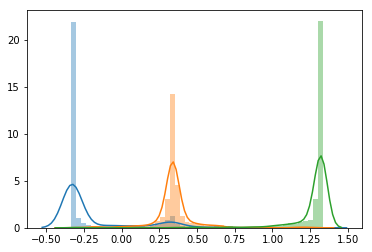

In [1302]:
sns.distplot(result[:, 0])
sns.distplot(result[:, 1])
sns.distplot(result[:, 2])

In [1303]:
np.count_nonzero((result[:, 1] > result[:, 0]) & (result[:, 2] > result[:, 1]))

916

In [1211]:
result.shape

(974, 3)

In [1]:
from signal_l.data_reader_writer import *

In [2]:
import pandas as pd

In [3]:
df = pd.DataFrame([{'id': 'a', 'product': 'b', 'the_date': 'c',
                   'side': 'b', 'data_type': 'd', 'data_content': 'e'
                   }])

In [4]:
df

,id,product,the_date,side,data_type,data_content
0,a,b,c,b,d,e


In [12]:
df.to_sql('FACTOR_SIGNAL', create_connection(ML_DB_PATH), if_exists = 'replace', index = None)

In [13]:
get_df_from_sql('select * from FACTOR_SIGNAL')

,id,product,the_date,side,data_type,data_content
0,a,b,c,b,d,e


In [9]:
execute_sql(create_connection(ML_DB_PATH), 'delete from FACTOR_SIGNAL')

In [14]:
import pandas as pd

In [15]:
d = pd.DataFrame(range(10))

In [20]:
d[0].apply(lambda x: pd.Series([2 * x, 2 * x  + 1]))

,0,1
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
5,10,11
6,12,13
7,14,15
8,16,17
9,18,19


In [1246]:
a = dict()

In [1248]:
a[1] = 2

In [1249]:
a.keys()

dict_keys([1])

In [21]:
train_label

array([5, 0, 4, ..., 5, 6, 8])

In [310]:
train_label_t = (train_label % 2) * 2 - 1

In [312]:
train_label

array([5, 0, 4, ..., 5, 6, 8])

In [314]:
test_label_t = (test_label % 2) *  2 - 1

In [464]:
import torch.nn.functional as F

In [614]:
INPUT_DIM = 28 ** 2
HIDDEN_DIM = INPUT_DIM // 2
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.h1 = nn.Linear(INPUT_DIM, 2 * INPUT_DIM)
        self.h5 = nn.Linear(2 * INPUT_DIM, 1)

    def predict(self, inp):
        x = F.tanh(self.h1(inp))
        x = self.h5(x)
        return x

    def forward(self, inp):
        x = self.predict(inp)
        return F.tanh(x)

In [615]:
p = FNet()

In [616]:
optimizer = optim.SGD(p.parameters(), lr = 1)
loader = Data.DataLoader(Data.TensorDataset(torch.FloatTensor(train_data), torch.FloatTensor(train_label_t)), 
                        batch_size = 250, shuffle = True)

In [625]:
for _ in range(1):    
    for _, (x, y) in enumerate(loader):
        
        x, y = Variable(x), Variable(y)
        oup = p(x)
        #loss = torch.sum(-y * oup)
        loss = torch.mean((y - oup) ** 2)
        #print(loss)
        #loss = torch.mean(-y * torch.log(oup))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


/Users/zhipeng/Library/Python/3.7/lib/python/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [626]:
train_result = p(Variable(torch.FloatTensor(train_data))).view(60000).detach().numpy()
test_result = p(Variable(torch.FloatTensor(test_data))).view(10000).detach().numpy()

In [627]:
#train_loss = np.mean((train_result - train_label_t) ** 2)
#test_loss = np.mean((test_result - test_label_t) ** 2)
train_loss = np.mean(-train_label_t * train_result)
test_loss = np.mean(-test_label_t * test_result)

In [628]:
eval(train_result, train_label_t)
eval(test_result, test_label_t)
train_loss, test_loss

0.546929267766345 0.5409217777084917
0.5424550232681657 0.5359495343860119


(0.016932764634490012, 0.014799465847015381)

In [602]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [442]:
def eval(pred, signal):
    aupr = average_precision_score(signal > 0, pred)
    auroc = roc_auc_score(signal > 0, pred)
    print(aupr, auroc)

0.6675161150492755 0.6928053173460174


In [578]:
test_result

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [579]:
test_label_t

array([ 1, -1,  1, ..., -1,  1, -1])

In [556]:
import seaborn as sb

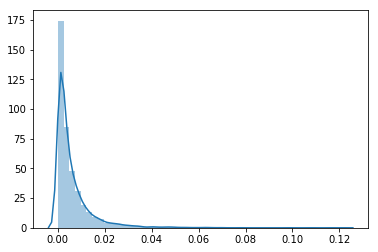

In [613]:
sb.distplot(test_result)